# Search parameter space for large whistler growth rate

### Let's consider 
- $\beta_i = 1$
- $T_c = T_i$
- $T_h / T_c = 3, 6, 9, 12, 15$
- $n_c / n_h = 0.7, 0.75, 0.8, 0.85, 0.9, 0.95$
- $v_A / c=2\times 10^{-4}$

for each set of parameters, search $v_{0c}/v_A = -1, -1.5, -2., ..., -10$
save
- max growth rate
- $v_{0c}/v_A$


In [ ]:
import sys, os
sys.path.insert(1, '../python')
sys.path.insert(1, os.path.join(os.environ['GOOGLE_DRIVE'], 'research/packages/vlasov_solver'))

import numpy as np
import pandas as pd
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

In [ ]:
def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

theta = 0
beta_0 = 1.
aol = 2e-4
tc_tp = 1
th_tc = 10.
nc_ne = 0.9
v0c = -5
a_list=[1., 1., 1.]
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
n = 10
method = 'numpy'

kdi = 1
target_kde = 1
target_kdi = target_kde * np.sqrt(1836)
target_k = kdi_2_krhoi(target_kdi, beta_0)
#--------------------------------
k = kdi_2_krhoi(kdi, beta_0)
kz, kp = kzkp(k, theta)


In [3]:
# search params:
all_th_tc = [2,4,6,8,10,12,14,16]
all_nc_ne = [0.7,0.75,0.8,0.85,0.9,0.95]
all_v0c = np.linspace(-1, -10, 19)

In [4]:
df_ckpt = 'data/large_growth_rate_whistler_search.pickle'
if os.path.exists(df_ckpt):
    df = pd.read_pickle(df_ckpt)
else:
    df = pd.DataFrame(columns=['th_tc', 'nc_ne', 'v0c', 'max_gamma', 'optimal_kde', 'optimal_omega'])

In [7]:
iteration = 0
for th_tc in all_th_tc:
    for nc_ne in all_nc_ne:
        for v0c in all_v0c:
            iteration += 1
            print(f'start iteration {iteration}')
            in_df = (df.th_tc == th_tc)
            in_df &= (df.nc_ne == nc_ne)
            in_df &= (df.v0c == v0c)
            if sum(in_df) > 0:
                continue
            t_list=[1., tc_tp, tc_tp * th_tc]
            n_list=[1.,nc_ne,1-nc_ne] 
            v_list=[0., v0c, -v0c * n_list[1] / n_list[2]]
            param = [kz, kp, beta_0, t_list, a_list, n_list, q_list,
                     m_list, v_list, n, method, aol]
            seed_freq = fast_freq(k, theta, beta_0)
            try:
                freq = follow_k(
                    seed_freq, target_k, param,log_incrmt = 0.01, incrmt_method = 'log'
                )
            except Exception:
                print(f'Encounter problems with th_tc={th_tc}, nc_nh={nc_nh} and v0c={v0c}')
                continue
            kde_start = kdi / np.sqrt(1836)
            kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(beta_0)
            kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq[-1]))
            freq_list = np.array(freq[-1])
            max_gamma = np.max(freq_list.imag)
            optimal_kde = kde_list[np.argmax(freq_list.imag)]
            optimal_omega = freq_list.real[np.argmax(freq_list.imag)]
            
            row = pd.DataFrame(
                [[th_tc, nc_ne, v0c, max_gamma, optimal_kde, optimal_omega]],
                columns=['th_tc', 'nc_ne', 'v0c', 'max_gamma', 'optimal_kde', 'optimal_omega']
            )
            df = df.append(row, ignore_index=True)
            
            if iteration % 50 == 0:
                print(f'save df to check points on iter {iteration}')
                df.to_pickle(df_ckpt)

start iteration 1
start iteration 2
start iteration 3
start iteration 4
start iteration 5
start iteration 6
start iteration 7
start iteration 8
start iteration 9
start iteration 10
start iteration 11
start iteration 12
start iteration 13
start iteration 14
start iteration 15
start iteration 16
start iteration 17
start iteration 18


/Users/tong/Envs/science/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


start iteration 19
start iteration 20
start iteration 21
start iteration 22
start iteration 23
start iteration 24
start iteration 25
start iteration 26
start iteration 27
start iteration 28
start iteration 29
start iteration 30
start iteration 31
start iteration 32
start iteration 33
start iteration 34
start iteration 35
start iteration 36
start iteration 37
start iteration 38
start iteration 39
start iteration 40
start iteration 41
start iteration 42
start iteration 43
start iteration 44
start iteration 45
start iteration 46
start iteration 47
start iteration 48
start iteration 49
start iteration 50
save df to check points on iter 50
start iteration 51
start iteration 52
start iteration 53
start iteration 54
start iteration 55
start iteration 56
start iteration 57


/Users/tong/Envs/science/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


start iteration 58
start iteration 59
start iteration 60
start iteration 61
start iteration 62
start iteration 63
start iteration 64
start iteration 65
start iteration 66
start iteration 67
start iteration 68
start iteration 69
start iteration 70
start iteration 71
start iteration 72
start iteration 73
start iteration 74
start iteration 75
start iteration 76
start iteration 77
start iteration 78
start iteration 79
start iteration 80
start iteration 81
start iteration 82
start iteration 83
start iteration 84
start iteration 85
start iteration 86
start iteration 87
start iteration 88
start iteration 89
start iteration 90
start iteration 91
start iteration 92
start iteration 93
start iteration 94
start iteration 95
start iteration 96
start iteration 97
start iteration 98
start iteration 99
start iteration 100
save df to check points on iter 100
start iteration 101
start iteration 102
start iteration 103
start iteration 104
start iteration 105
start iteration 106
start iteration 107
start 

/Users/tong/Google_Drive/research/packages/vlasov_solver/py_vlasov/util.py:64: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = 1.7724538509055159j * scipy.special.wofz(z)


start iteration 381
start iteration 382
start iteration 383
start iteration 384
start iteration 385
start iteration 386
start iteration 387
start iteration 388
start iteration 389
start iteration 390
start iteration 391
start iteration 392
start iteration 393
start iteration 394
start iteration 395
start iteration 396
start iteration 397
start iteration 398
start iteration 399
start iteration 400
save df to check points on iter 400
start iteration 401
start iteration 402
start iteration 403
start iteration 404
start iteration 405
start iteration 406
start iteration 407
start iteration 408
start iteration 409
start iteration 410
start iteration 411
start iteration 412
start iteration 413
start iteration 414
start iteration 415
start iteration 416
start iteration 417
start iteration 418
start iteration 419
start iteration 420
start iteration 421
start iteration 422
start iteration 423
start iteration 424
start iteration 425
start iteration 426
start iteration 427
start iteration 428
star

start iteration 777
start iteration 778
start iteration 779
start iteration 780
start iteration 781
start iteration 782
start iteration 783
start iteration 784
start iteration 785
start iteration 786
start iteration 787
start iteration 788
start iteration 789
start iteration 790
start iteration 791
start iteration 792
start iteration 793
start iteration 794
start iteration 795
start iteration 796
start iteration 797
start iteration 798
start iteration 799
start iteration 800
save df to check points on iter 800
start iteration 801
start iteration 802
start iteration 803
start iteration 804
start iteration 805
start iteration 806
start iteration 807
start iteration 808
start iteration 809
start iteration 810
start iteration 811
start iteration 812
start iteration 813
start iteration 814
start iteration 815
start iteration 816
start iteration 817
start iteration 818
start iteration 819
start iteration 820
start iteration 821
start iteration 822
start iteration 823
start iteration 824
star

In [45]:
cond_1 = df.max_gamma/1836 > 0.006
cond_2 = df.v0c > -7
cond_3 = df.th_tc < 11

In [46]:
sum(cond_1 & cond_2 & cond_3)

20

In [48]:
df[cond_1 & cond_2 & cond_3]

,th_tc,nc_ne,v0c,max_gamma,optimal_kde,optimal_omega
390,8,0.80,-6.0,11.889158,0.345183,164.196946
391,8,0.80,-6.5,13.332347,0.348632,164.047484
408,8,0.85,-5.5,12.202264,0.348632,165.380538
409,8,0.85,-6.0,13.201323,0.352115,164.784815
410,8,0.85,-6.5,14.015002,0.352115,161.946907
486,10,0.75,-6.5,12.397288,0.335041,156.926185
503,10,0.80,-5.5,12.327900,0.335041,158.297133
504,10,0.80,-6.0,14.279954,0.341769,160.341709
505,10,0.80,-6.5,16.085281,0.341769,158.096318
520,10,0.85,-4.5,11.546495,0.338388,161.966033


In [57]:
cond = (df.max_gamma/1836) > 1e-4
cond &= (df.v0c > -10)
cond &= (df.th_tc == 10)

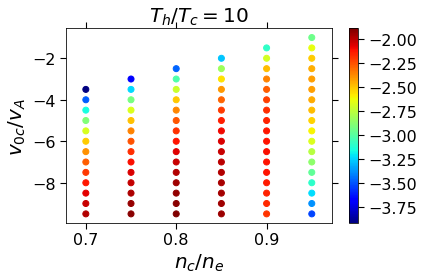

In [69]:
cond = (df.max_gamma/1836) > 1e-4
cond &= (df.v0c > -10)
cond &= (df.th_tc == 10)

df_sel = df[cond]
plt.scatter(df_sel.nc_ne, df_sel.v0c, c=np.log10(df_sel.max_gamma/1836), cmap='jet')
plt.colorbar()
plt.xlabel(r'$n_c/n_e$')
plt.ylabel(r'$v_{0c}/v_A$')
plt.title(r'$T_h/T_c=10$')
plt.tight_layout()
# plt.savefig('figure/whislter_gamma_vs_v0cva_ncne.png', dpi=100)

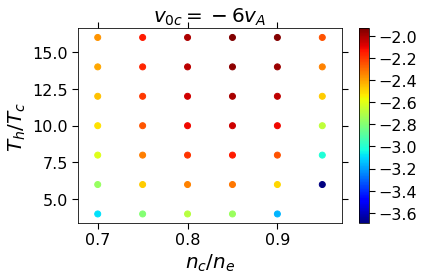

In [67]:
cond = (df.max_gamma/1836) > 1e-4
cond &= (df.v0c == -6)

df_sel = df[cond]
plt.scatter(df_sel.nc_ne, df_sel.th_tc, c=np.log10(df_sel.max_gamma/1836), cmap='jet')
plt.colorbar()
plt.xlabel(r'$n_c/n_e$')
plt.ylabel(r'$T_h/T_c$')
plt.title(r'$v_{0c}=-6v_A$')
plt.tight_layout()
# plt.savefig('figure/whislter_gamma_vs_thtc_ncne.png', dpi=100)